# Loan and repayment

##  Introduction

<strong>Q1:</strong> What factors have a significant impact on whether the loan is repaid or not? <br>
<strong>Q2:</strong> How will those factors affect the repayment of the loan?

For the solution of above questions, I utilized analyzable machine learning(xAI) <br>
Step 1: Feature engineering <br>
Step 2: Modeling <br>
Step 3: Use the 'Shap value' to find out which variables have the greatest impact <br>
Step 4: Check the relationship between the top five variables and repayment of loan <br>

In [83]:
import warnings
warnings.filterwarnings(action = 'ignore')
import pandas as pd

In [84]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
lb = pd.read_csv('./data/loan_before.csv')
# train.columns
# test.columns
# lb.columns

## 2. Feature engineering

Variabalize how many months the person should pay back the money.

In [85]:
train['AMT_CREDIT_TO_ANNUITY_RATIO'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
test['AMT_CREDIT_TO_ANNUITY_RATIO'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']

Use of Loan_Before(Previously recored data) to variabalize
<br>
<strong>1. Average after groupby (group by ID) </strong><br>
AMT_CREDIT_SUM: amount of the previous loan <br>
DATS_CREDIT: The number of days from previous loan. <br>
CNT_CREDIT_PROLONG(The number of loan extension <br>
<strong>2. After groupby(number of times by each person, How many times the person has taken out a loan in the past) </strong>

In [86]:
train = pd.merge(train, 
         lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(),
        on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, 
         lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(),
        on = 'SK_ID_CURR', how = 'left')

In [87]:
train = pd.merge(train, 
         lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(),
        on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, 
         lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(),
        on = 'SK_ID_CURR', how = 'left')

In [88]:
train = pd.merge(train, 
         lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(),
        on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, 
         lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(),
        on = 'SK_ID_CURR', how = 'left')

In [89]:
train = pd.merge(train, 
        lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns = {0:'count'}),
        on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, 
        lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns = {0:'count'}),
        on = 'SK_ID_CURR', how = 'left')

In [90]:
train.dtypes

SK_ID_CURR                       int64
TARGET                           int64
CODE_GENDER                    float64
FLAG_OWN_CAR                     int64
FLAG_OWN_REALTY                  int64
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                  float64
DAYS_ID_PUBLISH                  int64
OWN_CAR_AGE                    float64
CNT_FAM_MEMBERS                float64
HOUR_APPR_PROCESS_START          int64
ORGANIZATION_TYPE               object
EXT_SOURCE_1                   float64
EXT_SOURCE_2                   float64
EXT_SOURCE_3                   float64
DAYS_LAST_PHONE_CHANGE         float64
AMT_REQ_CREDIT_BUREAU_YEA

Categorical : 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_TYPE_SUITE ', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE' ,'NAME_HOUSING_TYPE' ,'ORGANIZATION_TYPE' <br>
Not explained: 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'    <br>

The purpose of this project is analyzing, so delete categorical values

In [91]:
del_list = ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE' ,'NAME_HOUSING_TYPE' ,'ORGANIZATION_TYPE',
           'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [92]:
train = train.drop(del_list, axis = 1)
test = test.drop(del_list, axis = 1)

In [93]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

## 3. Modeling

In [94]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

In [95]:
corr = train [input_var].corr()
corr.style.background_gradient()

High correlation values
- CNT_FAM_MEMBERS, CNT_CHILDREN
- AMT_CREDIT_TO_ANNUITY_RATIO, AMT_CREDIT
- AMT_ANNUITY, AMT_CREDIT

In [96]:
print(train['CNT_FAM_MEMBERS'].corr(train['TARGET']))
print(train['CNT_CHILDREN'].corr(train['TARGET']))

0.018876651698723254
0.025357359317616786


Need to delete one of values from each pairs <br>
Check the correlation between 'target'. delete lowest one (absolute)

In [97]:
del train['CNT_FAM_MEMBERS']
del test['CNT_FAM_MEMBERS']

In [98]:
print(train['AMT_CREDIT_TO_ANNUITY_RATIO'].corr(train['TARGET']))
print(train['AMT_CREDIT'].corr(train['TARGET']))

-0.024740288335190187
-0.022558430849347857


In [99]:
del train['AMT_CREDIT']
del test['AMT_CREDIT']

In [100]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

In [101]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

In [102]:
from xgboost import XGBClassifier

It sould be a tree model of random forest. From the models, XGBoost has high performence. 

In [103]:
model = XGBClassifier(n_estimators = 100, learning_rate = 0.1)

In [104]:
model.fit(train[input_var], train['TARGET'])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

## 4. Shap Value

In [105]:
import shap

In [106]:
shap_values = shap.TreeExplainer(model).shap_values(train[input_var])

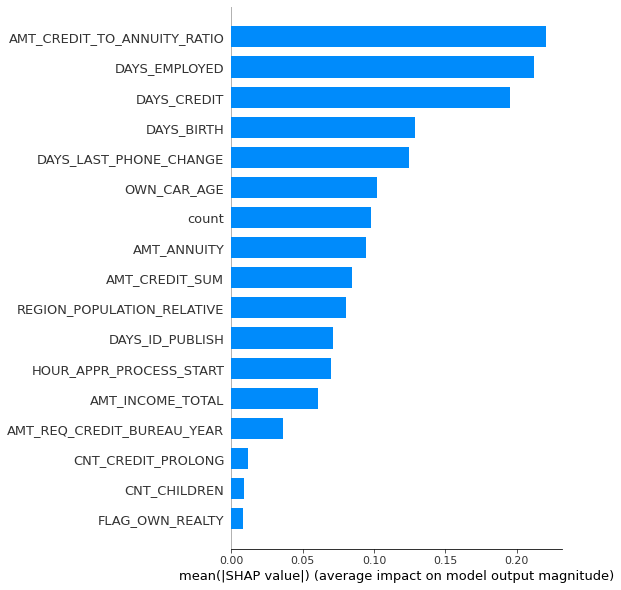

In [107]:
shap.summary_plot(shap_values, train[input_var], plot_type = 'bar')

After visualize, we can check top 5 variables for the result
<ul>
    <li>AMT_CREDIT_TO_ANNUITY_RATIO</li>
    <li>DAYS_EMPLOYED</li>
    <li>DAYS_CREDIT</li>
    <li>DAYS_BIRTH</li>
    <li>DAYS_LAST_PHONE_CHANGE</li>
</ul>

## 5. Find out the relationship between the five variables that have a lot of influence and repayment.

1. AMT_CREDIT_TO_ANNUITY_RATIO

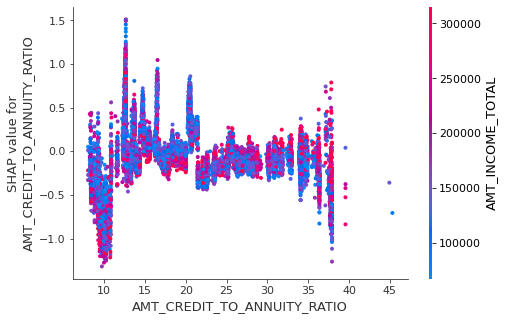

In [108]:
shap.dependence_plot('AMT_CREDIT_TO_ANNUITY_RATIO', shap_values, train[input_var])

When the loan repayment period is between 12 and 20 months, it is relatively poor.<br>
On the other hand, if it is less than 12 months or more, repayment is relatively good.

2. DAYS_EMPLOYED

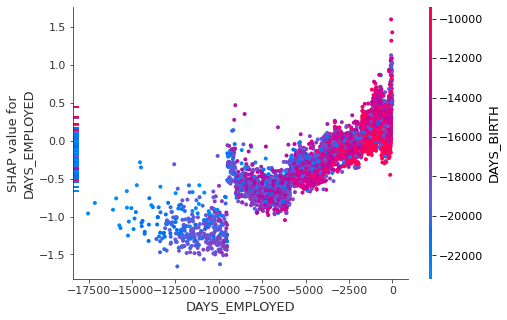

In [109]:
shap.dependence_plot('DAYS_EMPLOYED', shap_values, train[input_var])

The longer you get a job, the higher the probability of loan repayment.<br>
When employed longer than 9,000 days before the loan date, the loan repayment ability rises sharply.

3. DAYS_CREDIT

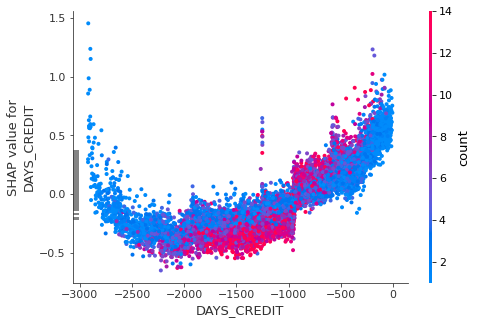

In [110]:
shap.dependence_plot('DAYS_CREDIT', shap_values, train[input_var])

From -3000 days to -2000 days, the loan repayment capacity will increase.<br>
It has since fallen.<br>

4. DAYS_BIRTH

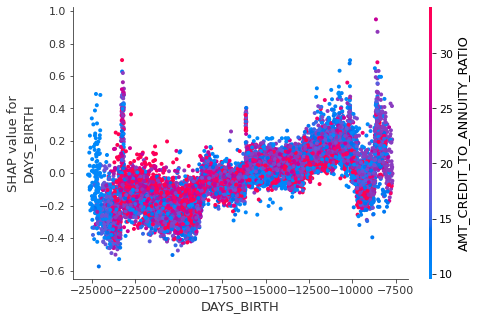

In [111]:
shap.dependence_plot('DAYS_BIRTH', shap_values, train[input_var])

The older you are, the better you tend to repay the loan.

5. DAYS_LAST_PHONE_CHANGE

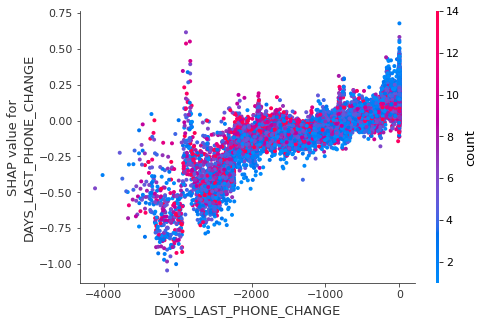

In [112]:
shap.dependence_plot('DAYS_LAST_PHONE_CHANGE', shap_values, train[input_var])

The longer you change your phone, the more likely you are to repay the loan.

## 6. Conclusion

1. The loan repayment period has the greatest impact on repayment. The effect is a nonlinear relationship (it is difficult to conclude that there is a causal relationship just because the impact is large)<br><br>
2. Whether or not you have a home and the number of children does not have a significant impact on your ability to repay the loan<br><br>
3. The more recent you get a job, the more recent you get a loan, the more recent you change your phone, the younger you are, the less likely you are to repay the loan.<br>
(The smaller DAYS_EMPLOYED, DAYS_CREDIT, DAYS_LAST_PHONE_CHANGE, DAYS_BIRTH is, the less likely it is to repay the loan)

In [113]:
# Group for ones who have lowest value for DAYS_EMPLOYED, DAYS_CREDIT, DAYS_LAST_PHONE_CHANGE, DAYS_BIRTH
group1 = train.loc[ (train['DAYS_EMPLOYED'].quantile(0.75)< train['DAYS_EMPLOYED']) &
           (train['DAYS_CREDIT'].quantile(0.75)< train['DAYS_CREDIT']) &
           (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.75)< train['DAYS_LAST_PHONE_CHANGE']) &
           (train['DAYS_BIRTH'].quantile(0.75)< train['DAYS_BIRTH']) ]

In [114]:
# Group for ones who have highest value for DAYS_EMPLOYED, DAYS_CREDIT, DAYS_LAST_PHONE_CHANGE, DAYS_BIRTH
group2 = train.loc[ (train['DAYS_EMPLOYED'].quantile(0.25)> train['DAYS_EMPLOYED']) &
           (train['DAYS_CREDIT'].quantile(0.25)> train['DAYS_CREDIT']) &
           (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.25)> train['DAYS_LAST_PHONE_CHANGE']) &
           (train['DAYS_BIRTH'].quantile(0.25)> train['DAYS_BIRTH']) ]

In [115]:
group1['group'] = 1
group2['group'] = 2

In [116]:
full = pd.concat([group1,group2],axis = 0)

In [117]:
import seaborn as sns

<AxesSubplot:xlabel='group', ylabel='TARGET'>

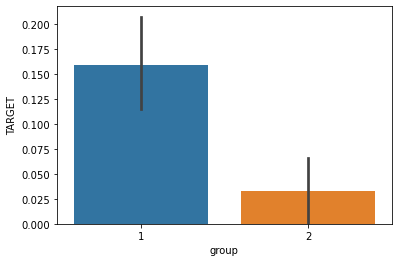

In [118]:
sns.barplot('group','TARGET',data=full)

If Target is high, then their possibility of repayment is low <br>
If Target is low, then their possibility of repayment is high